In [2]:
#import semua library yang diperlukan
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from transformers import pipeline

from keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout,GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.applications import VGG16
from keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import random as rn
import warnings
warnings.filterwarnings("ignore")

In [3]:
# untuk mengurangi jumlah warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [4]:
from tensorflow import keras
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.regularizers import l2

In [34]:
images = []
Labels = []
IMG_SIZE = 260
kawung = "/kaggle/input/batik-image-classification/Images/batik-kawung"
keraton = "/kaggle/input/batik-image-classification/Images/batik-keraton"
lasem = "/kaggle/input/batik-image-classification/Images/batik-lasem"

# kawung = "/kaggle/input/d/phoebepw/batik-image-classification/batik-kawung/batik-kawung"
# keraton = "/kaggle/input/d/phoebepw/batik-image-classification/batik-keraton/batik-keraton"
# lasem = "/kaggle/input/d/phoebepw/batik-image-classification/batik-lasem/batik-lasem"

In [6]:
import os
import cv2
from skimage.feature import local_binary_pattern

In [35]:
def make_train_data(batik_type, DIR):
    for img in tqdm(os.listdir(DIR)):
        if img.endswith(".jpg") or img.endswith(".png"):
            path = os.path.join(DIR, img)
            image = cv2.imread(path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            images.append(image)
            Labels.append(str(batik_type))

In [36]:
make_train_data('Batik Kawung',kawung)
print(len(images))
make_train_data('Batik Keraton',keraton)
print(len(images))
make_train_data('Batik Lasem',lasem)
print(len(images))

100%|██████████| 45/45 [00:00<00:00, 77.42it/s]


45


100%|██████████| 50/50 [00:00<00:00, 72.32it/s]


95


100%|██████████| 50/50 [00:00<00:00, 100.16it/s]

145


In [12]:
print(Labels)

['Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Kawung', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik Keraton', 'Batik 

Splitting image into train and test set

In [41]:
x_train2,x_test2,y_train2,y_test2=train_test_split(images,Labels,test_size=0.2,random_state=42)

In [42]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Initialize LabelEncoder and OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

y_train2 = le.fit_transform(y_train2)
y_train2 = y_train2.reshape(-1, 1)

y_train2 = ohe.fit_transform(y_train2)

y_test2 = le.transform(y_test2)
y_test2 = y_test2.reshape(-1, 1)
y_test2 = ohe.transform(y_test2)

print(y_train2[:10])
print(y_test2[:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [43]:
def compute_lbp(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    return lbp

# Function to compute LBP features for a dataset
def compute_lbp_features(images):
    lbp_features = []
    for image in images:
        lbp = compute_lbp(image)
        lbp_features.append(lbp)
    return np.array(lbp_features)

In [44]:
x_train2 = compute_lbp_features(x_train2)
x_test2 = compute_lbp_features(x_test2)

In [45]:
# Normalize LBP images
x_train2 = np.array(x_train2).astype('float32') / 255.0
x_train2 = x_train2.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # LBP images have a single channel

print(x_train2.shape)
print(y_train2[:5])

(116, 260, 260, 1)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [46]:
# Normalize LBP images
x_test2 = np.array(x_test2).astype('float32') / 255.0
x_test2 = x_test2.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # LBP images have a single channel

print(x_test2.shape)
print(y_test2[:5])

(29, 260, 260, 1)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


## **Data Augmentation**

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train2)

In [48]:
train_datagen2 = datagen.flow(x_train2, y_train2, batch_size=5)

## **Modelling**

Transfer learning, EfficientNet-B2

In [49]:
NUM_CLASSES = 3

In [25]:
pretrained_model = EfficientNetB2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)
pretrained_model.summary()
pretrained_model.trainable = False

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 260, 260,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 260, 260,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 261, 261,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 130, 130,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 130, 130,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 130, 130,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 130, 130,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │        512 │ block1a_se_excit

 Total params: 7,768,569 (29.63 MB)

 Trainable params: 7,700,994 (29.38 MB)

 Non-trainable params: 67,575 (263.97 KB)

Completing and compiling model

In [50]:
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = pretrained_model(inputs, training=False)
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Dropout(0.5, name="top_dropout")(x)
outputs = Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)
eff_b2 = Model(inputs, outputs)

In [51]:
optimizer = Adam(learning_rate=1e-2)
eff_b2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [53]:
from tensorflow.keras.callbacks import ModelCheckpoint
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
checkpoint_path = '/kaggle/working/best_model.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min')

In [54]:
epochs = 30 
batch_size = 5

Epoch 1/30


W0000 00:00:1719158449.063849      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 - 69s - 3s/step - accuracy: 0.2414 - loss: 4.1111
Epoch 2/30
24/24 - 2s - 71ms/step - accuracy: 0.2845 - loss: 3.5478
Epoch 3/30
24/24 - 1s - 34ms/step - accuracy: 0.3190 - loss: 3.8315
Epoch 4/30
24/24 - 1s - 34ms/step - accuracy: 0.3448 - loss: 3.6017
Epoch 5/30
24/24 - 2s - 70ms/step - accuracy: 0.3362 - loss: 3.2278
Epoch 6/30
24/24 - 1s - 35ms/step - accuracy: 0.4138 - loss: 3.3915
Epoch 7/30
24/24 - 2s - 68ms/step - accuracy: 0.3362 - loss: 2.5448
Epoch 8/30
24/24 - 1s - 34ms/step - accuracy: 0.3793 - loss: 2.9450
Epoch 9/30
24/24 - 1s - 34ms/step - accuracy: 0.2845 - loss: 3.2593
Epoch 10/30
24/24 - 1s - 35ms/step - accuracy: 0.3017 - loss: 3.1459
Epoch 11/30
24/24 - 1s - 34ms/step - accuracy: 0.4397 - loss: 2.7257
Epoch 12/30
24/24 - 1s - 33ms/step - accuracy: 0.3966 - loss: 3.0249
Epoch 13/30
24/24 - 1s - 34ms/step - accuracy: 0.3448 - loss: 3.3818
Epoch 14/30
24/24 - 1s - 34ms/step - accuracy: 0.3276 - loss: 3.4310
Epoch 15/30
24/24 - 1s - 34ms/step - accuracy: 0.2931 -

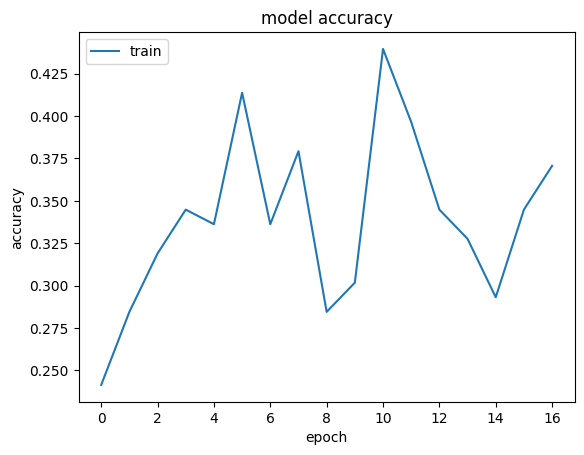

In [55]:
hist = eff_b2.fit(train_datagen2, epochs=epochs, batch_size = batch_size, verbose=2, callbacks=[early_stopping, checkpoint])
plot_hist(hist)

In [56]:
if os.path.exists(checkpoint_path):
    eff_b2.load_weights(checkpoint_path)
    test_loss, test_accuracy = eff_b2.evaluate(x_test2, y_test2, verbose=2)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
else:
    print("No checkpoint created. Please check if the loss improved during training.")

1/1 - 17s - 17s/step - accuracy: 0.2759 - loss: 1.1435
Test Loss: 1.1434876918792725
Test Accuracy: 0.27586206793785095


W0000 00:00:1719158511.846787      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Model from scratch

In [57]:
input_1ch = (260,260,1)

In [58]:
def new_model(input_shape, num_classes=3):
    input_layer = layers.Input(shape=input_shape, name='input_layer')
    x = layers.Rescaling(1.0 / 255)(input_layer)
    x = layers.Conv2D(128, 3, strides=2, padding="same", kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same", activity_regularizer=l2(0.001))(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same", activity_regularizer=l2(0.001))(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.Dropout(0.5)(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same", kernel_regularizer=l2(0.001))(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same", activity_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)

    output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
    model = Model(inputs=input_layer, outputs=output_layer, name='new_model')
    return model

Epoch 1/30
24/24 - 43s - 2s/step - accuracy: 0.3103 - loss: 1.4702
Epoch 2/30
24/24 - 2s - 91ms/step - accuracy: 0.3621 - loss: 1.2616
Epoch 3/30
24/24 - 2s - 93ms/step - accuracy: 0.3276 - loss: 1.1425
Epoch 4/30
24/24 - 2s - 91ms/step - accuracy: 0.4914 - loss: 1.1051
Epoch 5/30
24/24 - 2s - 92ms/step - accuracy: 0.4310 - loss: 1.0847
Epoch 6/30
24/24 - 2s - 91ms/step - accuracy: 0.4224 - loss: 1.0653
Epoch 7/30
24/24 - 2s - 83ms/step - accuracy: 0.3448 - loss: 1.0935
Epoch 8/30
24/24 - 2s - 89ms/step - accuracy: 0.4397 - loss: 1.0639
Epoch 9/30
24/24 - 2s - 90ms/step - accuracy: 0.4397 - loss: 1.0575
Epoch 10/30
24/24 - 2s - 90ms/step - accuracy: 0.3966 - loss: 1.0477
Epoch 11/30
24/24 - 2s - 83ms/step - accuracy: 0.4397 - loss: 1.0692
Epoch 12/30
24/24 - 2s - 82ms/step - accuracy: 0.4483 - loss: 1.0637
Epoch 13/30
24/24 - 2s - 84ms/step - accuracy: 0.4397 - loss: 1.0580
Epoch 14/30
24/24 - 2s - 82ms/step - accuracy: 0.4483 - loss: 1.0705
Epoch 15/30
24/24 - 2s - 88ms/step - accurac

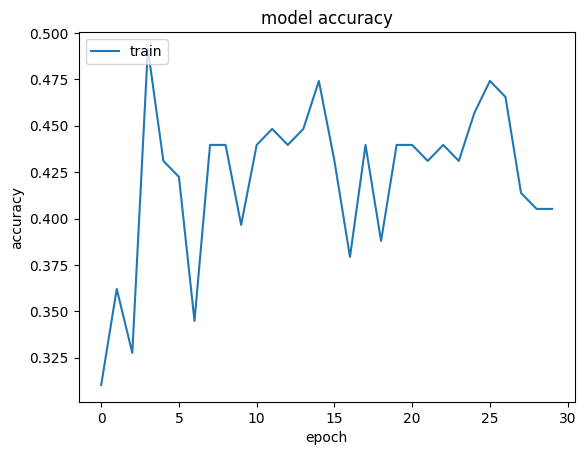

In [59]:
model = new_model(input_1ch)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model, show_shapes=True)
hist = model.fit(train_datagen2, epochs=epochs, batch_size = 5, verbose=2, callbacks=[early_stopping, checkpoint])
plot_hist(hist)

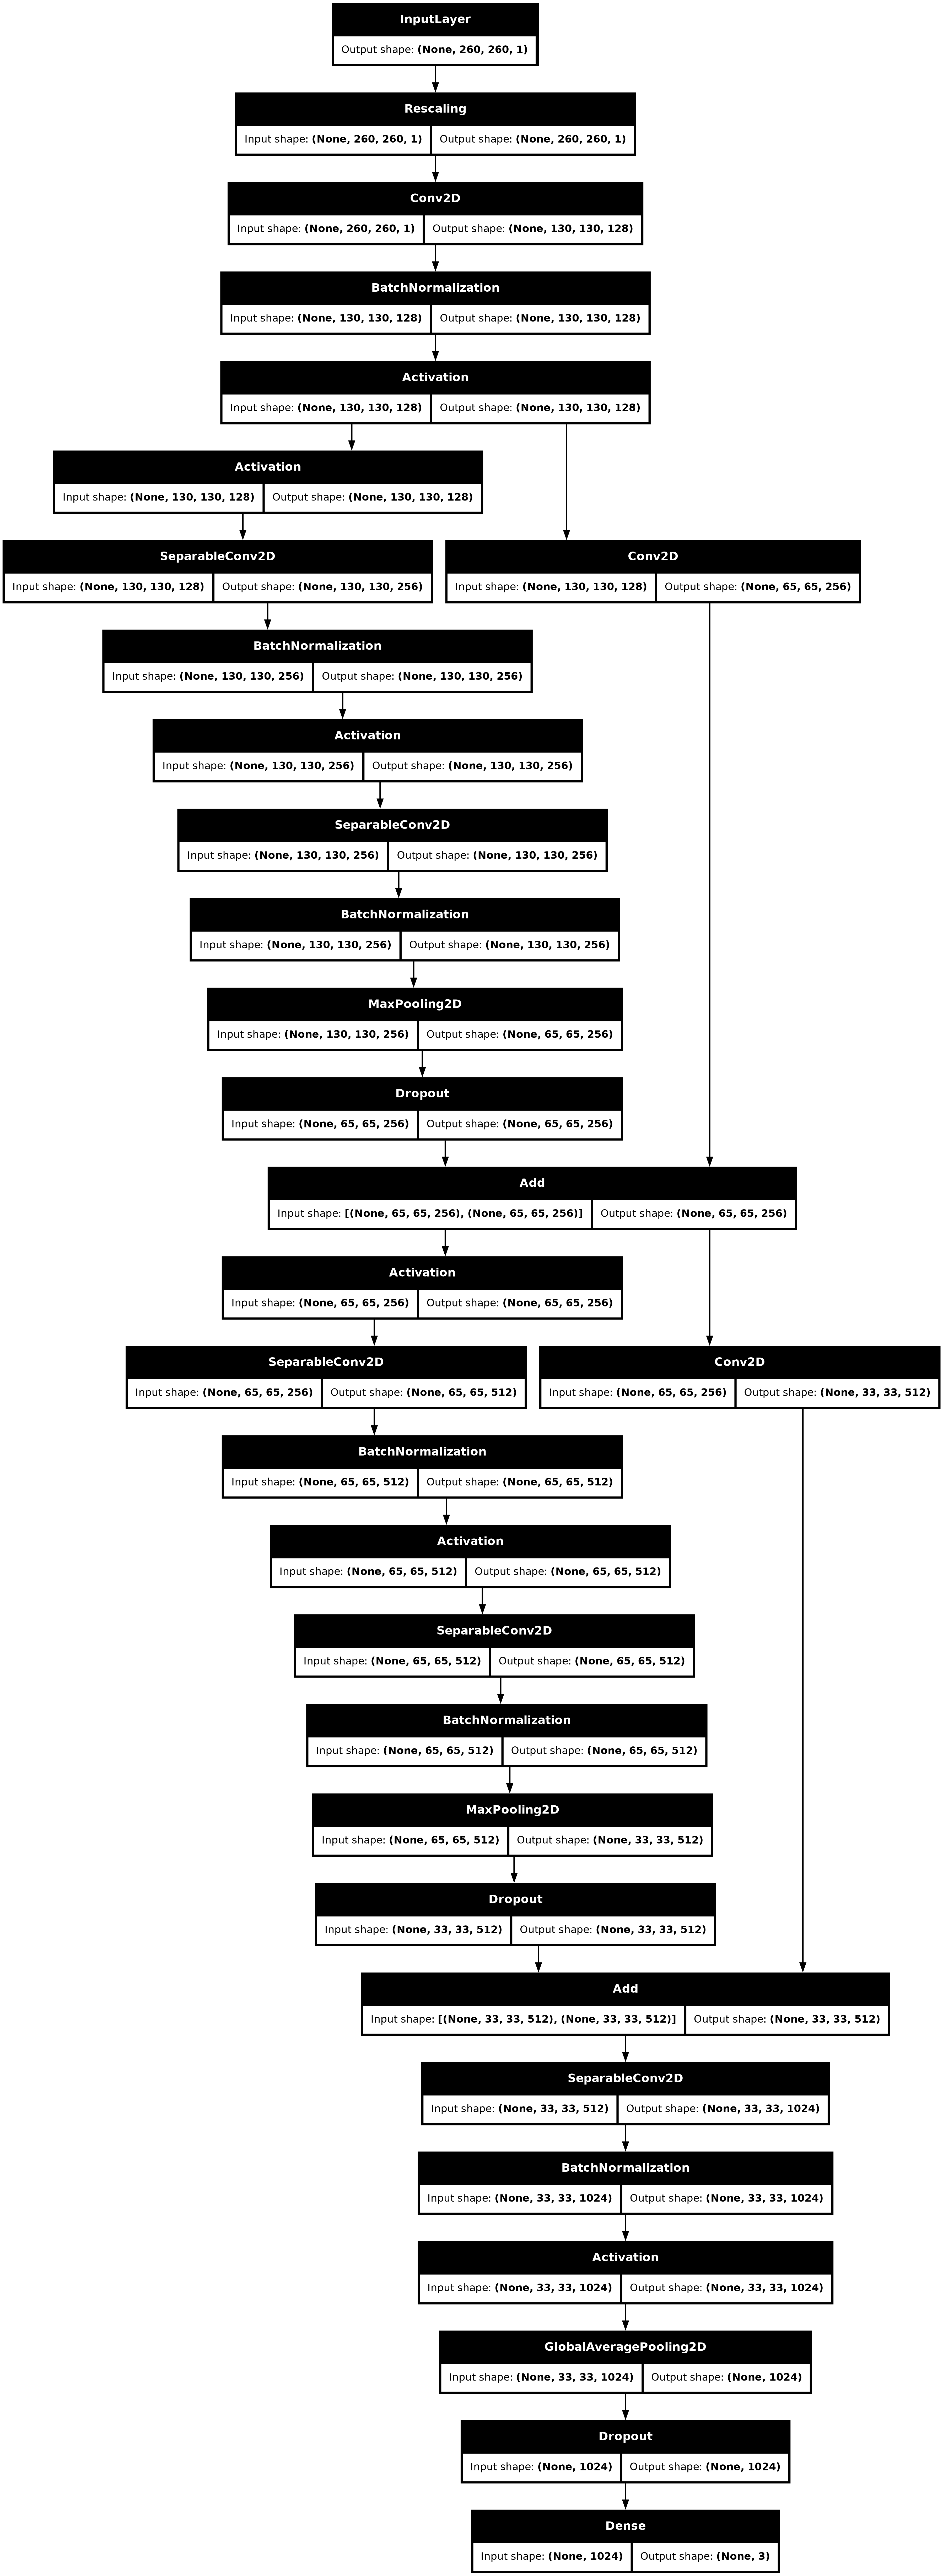

In [63]:
keras.utils.plot_model(model, show_shapes=True)

In [61]:
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    test_loss, test_accuracy = model.evaluate(x_test2, y_test2, verbose=2)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
else:
    print("No checkpoint created. Please check if the loss improved during training.")

1/1 - 0s - 125ms/step - accuracy: 0.3793 - loss: 3.5381
Test Loss: 3.53810977935791
Test Accuracy: 0.37931033968925476


versi model dimana separable convolution diganti conv2d

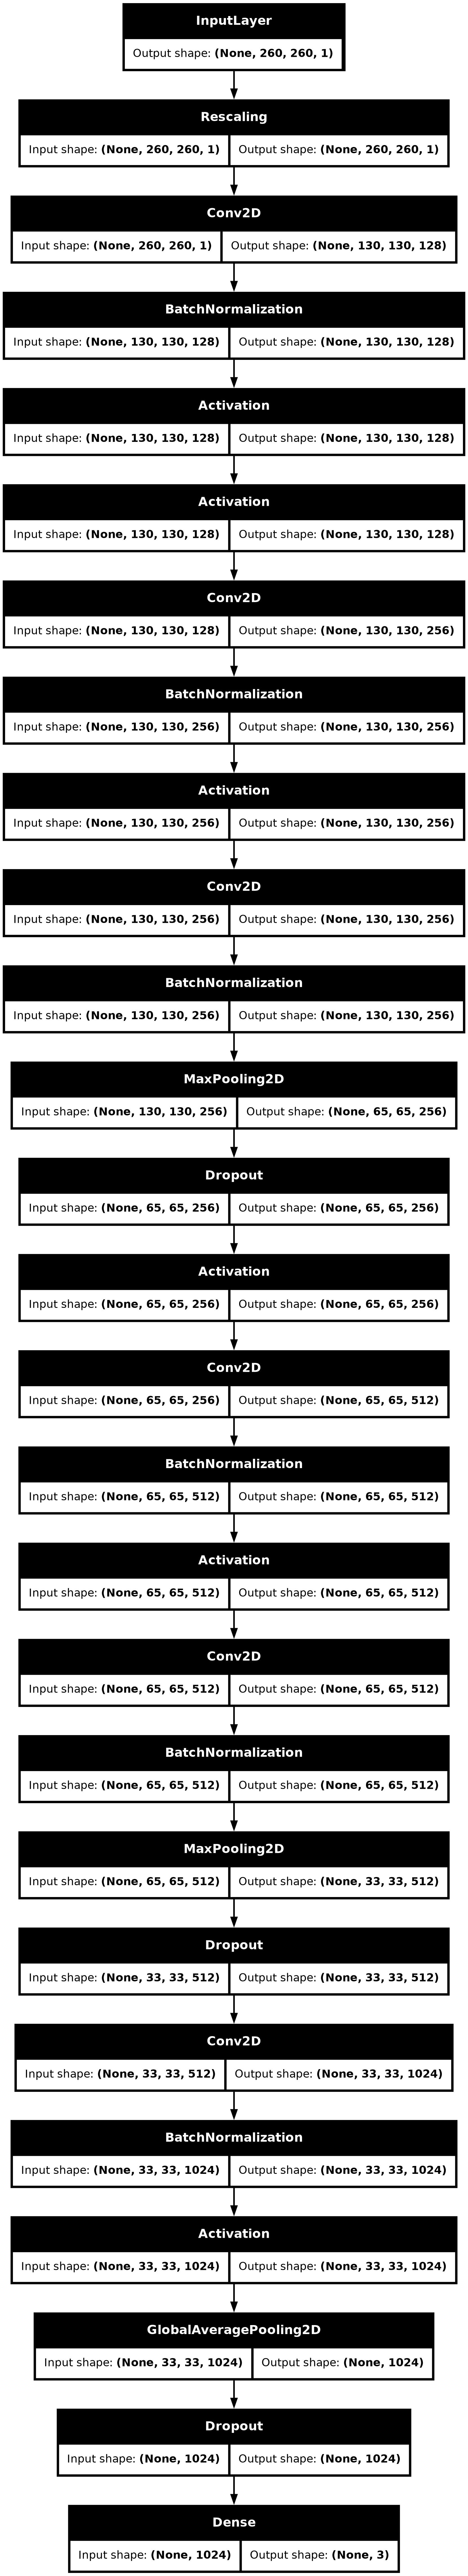

In [62]:
def new_model2(input_shape=(260, 260, 1), num_classes=NUM_CLASSES):
    input_layer = layers.Input(shape=input_shape, name='input_layer')
    # Entry block
    x = layers.Rescaling(1.0 / 255)(input_layer)
    x = layers.Conv2D(128, 3, strides=2, padding="same", kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same", kernel_regularizer=l2(0.001))(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same", kernel_regularizer=l2(0.001))(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.Dropout(0.5)(x)


    x = layers.Conv2D(1024, 3, padding="same", kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)

    output_layer = layers.Dense(units, activation='softmax', name='output_layer')(x)
    model = Model(inputs=input_layer, outputs=output_layer, name='new_model2')
    return model


model2 = new_model2()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model2, show_shapes=True)


Epoch 1/30
24/24 - 70s - 3s/step - accuracy: 0.3103 - loss: 3.3007
Epoch 2/30
24/24 - 5s - 211ms/step - accuracy: 0.2759 - loss: 2.8379
Epoch 3/30
24/24 - 5s - 215ms/step - accuracy: 0.3362 - loss: 2.4264
Epoch 4/30
24/24 - 5s - 217ms/step - accuracy: 0.3621 - loss: 2.1043
Epoch 5/30
24/24 - 5s - 221ms/step - accuracy: 0.3190 - loss: 1.8573
Epoch 6/30
24/24 - 5s - 224ms/step - accuracy: 0.2500 - loss: 1.7417
Epoch 7/30
24/24 - 5s - 221ms/step - accuracy: 0.3362 - loss: 1.5827
Epoch 8/30
24/24 - 5s - 217ms/step - accuracy: 0.2931 - loss: 1.5829
Epoch 9/30
24/24 - 5s - 216ms/step - accuracy: 0.3190 - loss: 1.4886
Epoch 10/30
24/24 - 5s - 216ms/step - accuracy: 0.3707 - loss: 1.3826


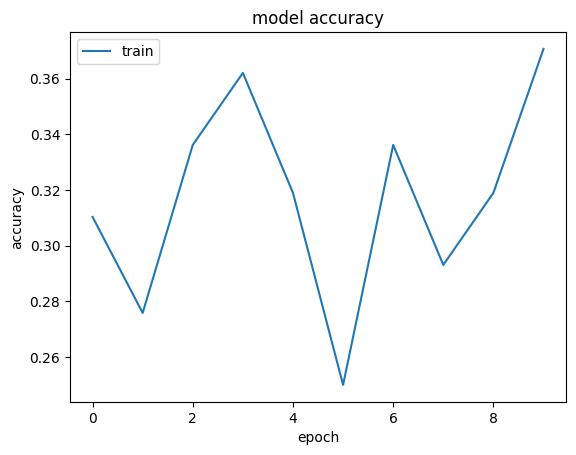

In [64]:
hist = model2.fit(train_datagen2, epochs=epochs, batch_size= 5, verbose=2, callbacks=[early_stopping, checkpoint])
plot_hist(hist)

In [66]:
if os.path.exists(checkpoint_path):
#     model2.load_weights(checkpoint_path)
#   perubahan di model 2 tidak cukup signifikan untuk disave ke dalam checkpoint
    test_loss, test_accuracy = model2.evaluate(x_test2, y_test2, verbose=2)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
else:
    print("No checkpoint created. Please check if the loss improved during training.")

2024-06-23 16:11:30.418853: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[29,256,130,130]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,256,130,130]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-23 16:11:30.438592: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.019857646s
Trying algorithm eng11{k2=4,k3=0} for conv (f32[29,256,130,130]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,256,130,130]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_al

1/1 - 76s - 76s/step - accuracy: 0.3448 - loss: 124670856.0000
Test Loss: 124670856.0
Test Accuracy: 0.3448275923728943


In [ ]:
# Code to check checkpoint, karena ada kalanya model tidak memiliki perubahan yang besar sehingga tidak tersimpan dalam checkpoint
# print("Model Summary:")
# print(model3.summary())

# # Load and print summary of the saved model
# from tensorflow.keras.models import load_model
# saved_model = load_model(checkpoint_path)
# print("Saved Model Summary:")
# print(saved_model.summary())


model 3 = model 2 but gaada regularizer

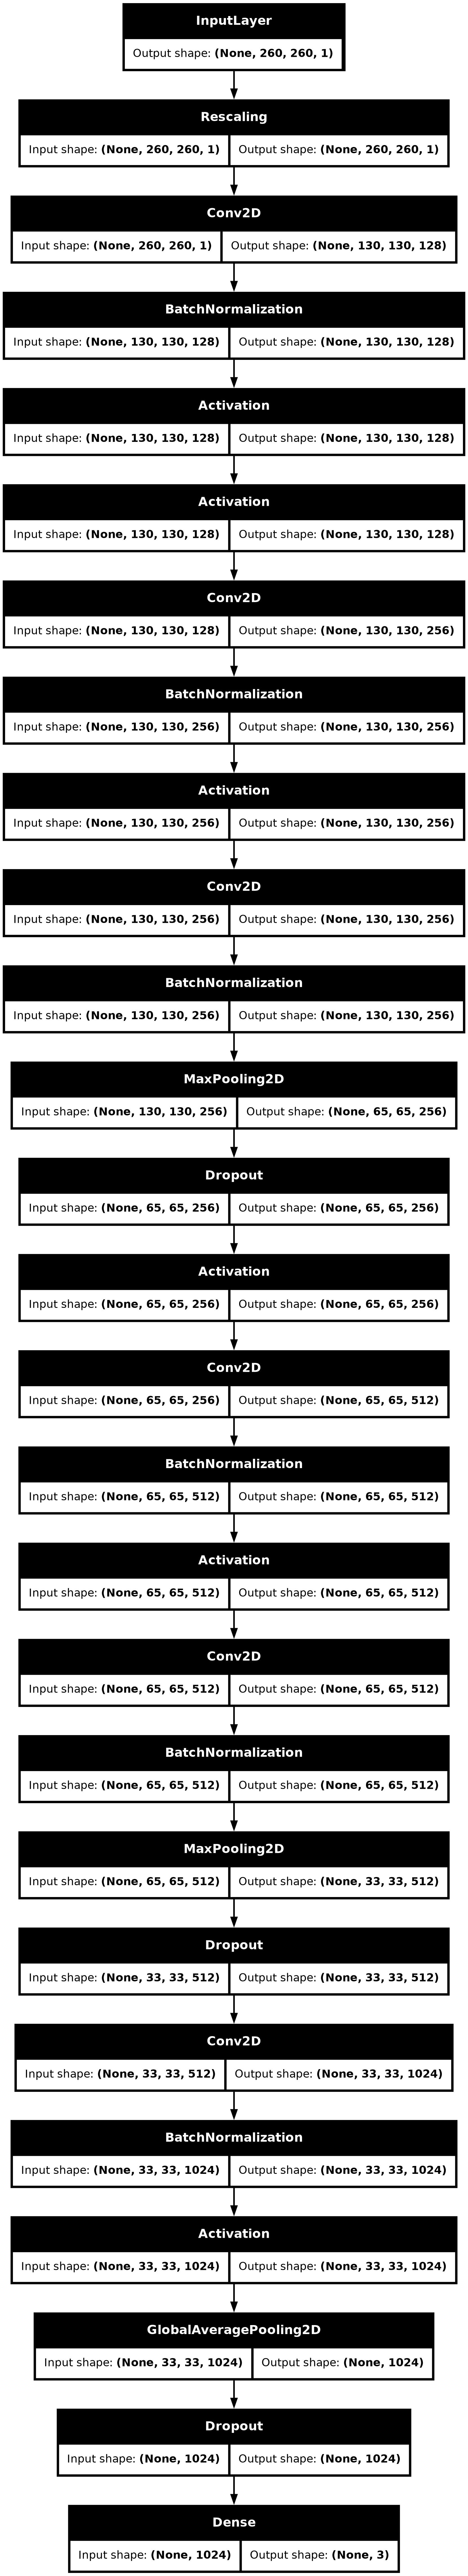

In [67]:
def new_model3(input_shape=(260, 260, 1), num_classes=NUM_CLASSES):
    input_layer = layers.Input(shape=input_shape, name='input_layer')
    # Entry block
    x = layers.Rescaling(1.0 / 255)(input_layer)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.Dropout(0.5)(x)


    x = layers.Conv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)

    output_layer = layers.Dense(units, activation='softmax', name='output_layer')(x)
    model = Model(inputs=input_layer, outputs=output_layer, name='new_model3')
    return model


model3 = new_model3()
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model3, show_shapes=True)


Training the model

Epoch 1/30
24/24 - 22s - 914ms/step - accuracy: 0.4138 - loss: 1.2833
Epoch 2/30
24/24 - 5s - 209ms/step - accuracy: 0.3362 - loss: 1.1246
Epoch 3/30
24/24 - 5s - 213ms/step - accuracy: 0.3362 - loss: 1.1237
Epoch 4/30
24/24 - 5s - 216ms/step - accuracy: 0.3534 - loss: 1.1434
Epoch 5/30
24/24 - 5s - 220ms/step - accuracy: 0.4741 - loss: 1.0811
Epoch 6/30
24/24 - 5s - 223ms/step - accuracy: 0.3362 - loss: 1.1825
Epoch 7/30
24/24 - 5s - 223ms/step - accuracy: 0.3793 - loss: 1.1214
Epoch 8/30
24/24 - 5s - 221ms/step - accuracy: 0.3621 - loss: 1.1510
Epoch 9/30
24/24 - 5s - 217ms/step - accuracy: 0.4138 - loss: 1.0936
Epoch 10/30
24/24 - 5s - 217ms/step - accuracy: 0.3103 - loss: 1.1193


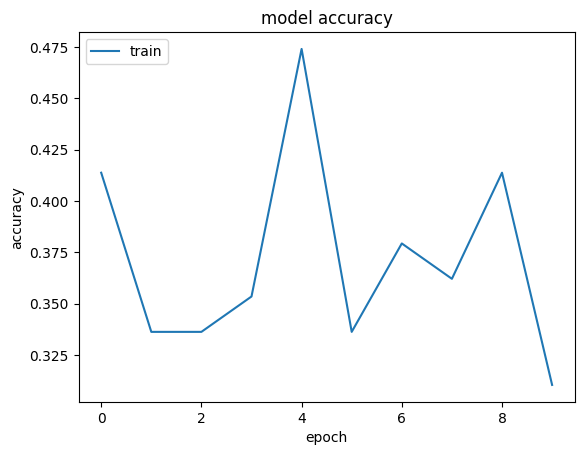

In [68]:
hist = model3.fit(train_datagen2, epochs=epochs, batch_size = 5, verbose=2, callbacks=[early_stopping, checkpoint])
plot_hist(hist)

In [70]:
if os.path.exists(checkpoint_path):
#     model3.load_weights(checkpoint_path)
#   model 3 tidak memiliki perubahan yang signifikan dibanding model 1, sehingga checkpoint tidak tersimpan
    test_loss, test_accuracy = model3.evaluate(x_test2, y_test2, verbose=2)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
else:
    print("No checkpoint created. Please check if the loss improved during training.")

W0000 00:00:1719159380.803009      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 - 1s - 1s/step - accuracy: 0.3448 - loss: 21866950.0000
Test Loss: 21866950.0
Test Accuracy: 0.3448275923728943


In [71]:
model.summary()

Model: "new_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 260, 260,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 130, 130,  │      1,280 │ rescaling_2[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 130, 130,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 130, 130,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 130, 130,  │          0 │ activation[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 130, 130,  │     34,176 │ activation_1[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 130, 130,  │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 130, 130,  │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 130, 130,  │     68,096 │ activation_2[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 130, 130,  │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 65, 65,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 65, 65,    │          0 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 65, 65,    │     33,024 │ activation[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 65, 65,    │          0 │ dropout[0][0],    │
│                     │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 65, 65,    │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 65, 65,    │    133,888 │ activation_3[0][

 Total params: 3,628,427 (13.84 MB)

 Trainable params: 1,207,683 (4.61 MB)

 Non-trainable params: 5,376 (21.00 KB)

 Optimizer params: 2,415,368 (9.21 MB)

In [72]:
model2.summary()

Model: "new_model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 260, 260, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 260, 260, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 130, 130, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 130, 130, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 130, 130, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 130, 130, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 130, 130, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 130, 130, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 130, 130, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 130, 130, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 130, 130, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 65, 65, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 65, 65, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 65, 65, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 65, 65, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 65, 65, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 65, 65, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 65, 65, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 65, 65, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 33, 33, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 33, 33, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 33, 33, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,469,067 (104.79 MB)

 Trainable params: 9,154,563 (34.92 MB)

 Non-trainable params: 5,376 (21.00 KB)

 Optimizer params: 18,309,128 (69.84 MB)

In [73]:
model3.summary()

Model: "new_model3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 260, 260, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 260, 260, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 130, 130, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 130, 130, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 130, 130, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 130, 130, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 130, 130, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 130, 130, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 130, 130, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 130, 130, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 130, 130, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 65, 65, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 65, 65, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 65, 65, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 65, 65, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 65, 65, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 65, 65, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 65, 65, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 65, 65, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 33, 33, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 33, 33, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 33, 33, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,469,067 (104.79 MB)

 Trainable params: 9,154,563 (34.92 MB)

 Non-trainable params: 5,376 (21.00 KB)

 Optimizer params: 18,309,128 (69.84 MB)